# Feed Forward Neural Network - Dropout

In [1]:
import numpy as np
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam
from keras.initializers import RandomNormal, RandomUniform

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Generate data

In [2]:
n_data = 2000
n_periods = 3
a = -0.5; b = 0.5
a2 = -0.1; b2 = 0.1
x_data_full = np.linspace(a, b, n_data)
x_data_full = np.reshape(x_data_full, (n_data, 1))
y_data_full = np.sin(2*np.pi*n_periods*x_data_full/(b-a))+np.random.normal(loc=0, scale=0.2, size=(n_data,1))
x_data_gap = np.concatenate((np.linspace(a, a2, int(n_data/2)), np.linspace(b2, b, int(n_data/2))), axis=0)
x_data_gap = np.reshape(x_data_gap, (n_data, 1))
y_data_gap = np.sin(2*np.pi*n_periods*x_data_gap/(b-a))+np.random.normal(loc=0, scale=0.2, size=(n_data,1))


n_pred = 2000
X_pred = np.reshape(np.linspace(1.25*a, 1.25*b, n_pred), (n_pred, 1))
y_pred = np.sin(2*np.pi*n_periods*X_pred/(b-a))
print('One period is {0} data points.'.format(n_data/n_periods))

One period is 666.6666666666666 data points.


### Full

No handles with labels found to put in legend.


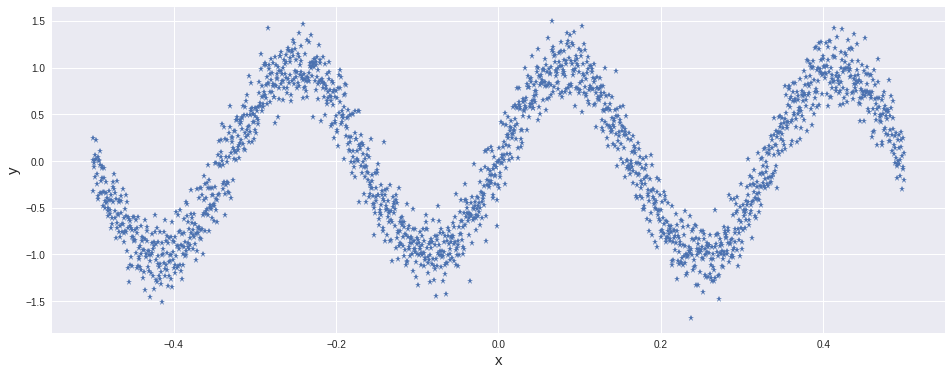

In [3]:
plt.figure(figsize=(16,6))
plt.plot(x_data_full, y_data_full, '*')
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.legend(fontsize=20)
plt.show()

No handles with labels found to put in legend.


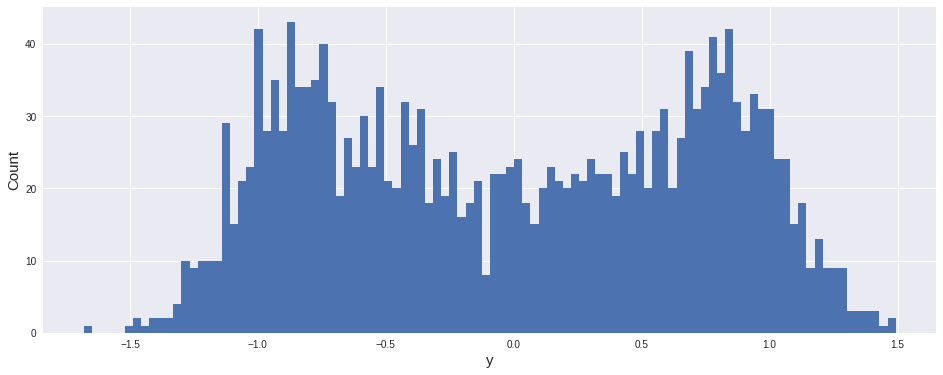

In [4]:
plt.figure(figsize=(16,6))
plt.hist(y_data_full, bins=100)
plt.xlabel('y', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.legend(fontsize=20)
plt.show()

### Gap

No handles with labels found to put in legend.


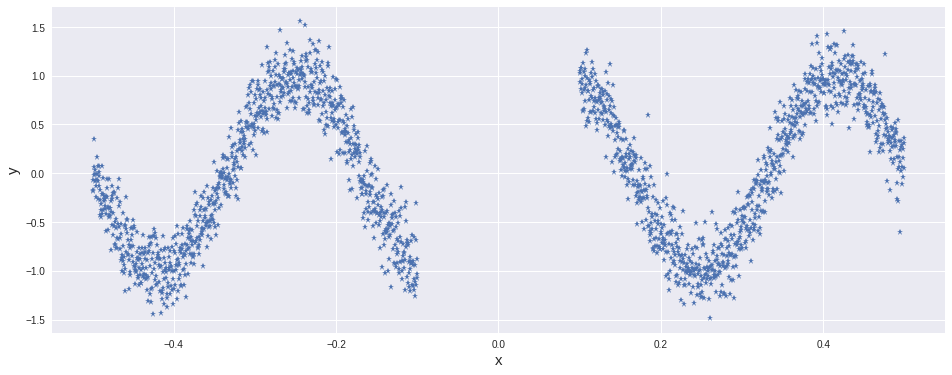

In [5]:
plt.figure(figsize=(16,6))
plt.plot(x_data_gap, y_data_gap, '*')
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.legend(fontsize=20)
plt.show()

No handles with labels found to put in legend.


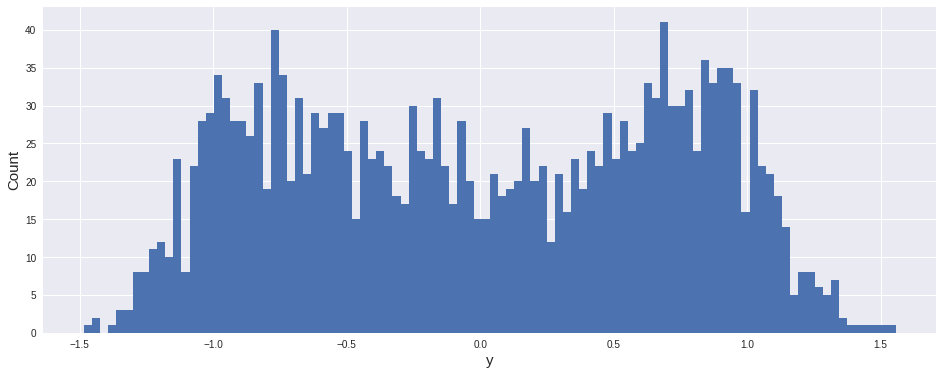

In [6]:
plt.figure(figsize=(16,6))
plt.hist(y_data_gap, bins=100)
plt.xlabel('y', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.legend(fontsize=20)
plt.show()

## Create supervised problem

In [0]:
test_size = 0.25
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(x_data_full, y_data_full, test_size=test_size, shuffle=True)
X_train_gap, X_test_gap, y_train_gap, y_test_gap = train_test_split(x_data_gap, y_data_gap, test_size=test_size, shuffle=True)

In [8]:
print('Data points in train set: {0}.'.format(len(X_train_full)))
print('Data points in test set: {0}.'.format(len(X_test_full)))
print("Shape of features in training data: {}".format(X_train_full.shape))
print("Shape of output in training data: {}".format(y_train_full.shape))
print("Shape of features in test data: {}".format(X_test_full.shape))
print("Shape of output in test data: {}".format(y_test_full.shape))

Data points in train set: 1500.
Data points in test set: 500.
Shape of features in training data: (1500, 1)
Shape of output in training data: (1500, 1)
Shape of features in test data: (500, 1)
Shape of output in test data: (500, 1)


### Full

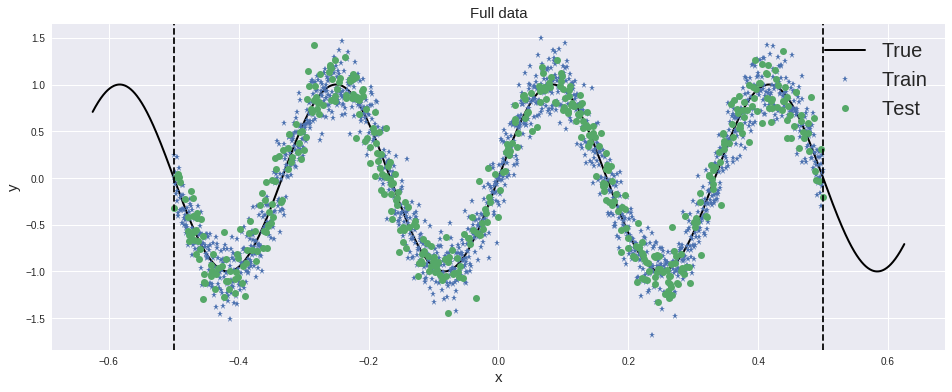

In [9]:
plt.figure(figsize=(16,6))
plt.plot(X_pred, y_pred, '-k', linewidth=2.0, label='True')
plt.plot(X_train_full, y_train_full, '*', label='Train')
plt.plot(X_test_full, y_test_full, 'o', label='Test')
plt.axvline(x=a, color='k', linestyle='--')
plt.axvline(x=b, color='k', linestyle='--')
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.title('Full data', fontsize=15)
plt.legend(fontsize=20)
plt.show()

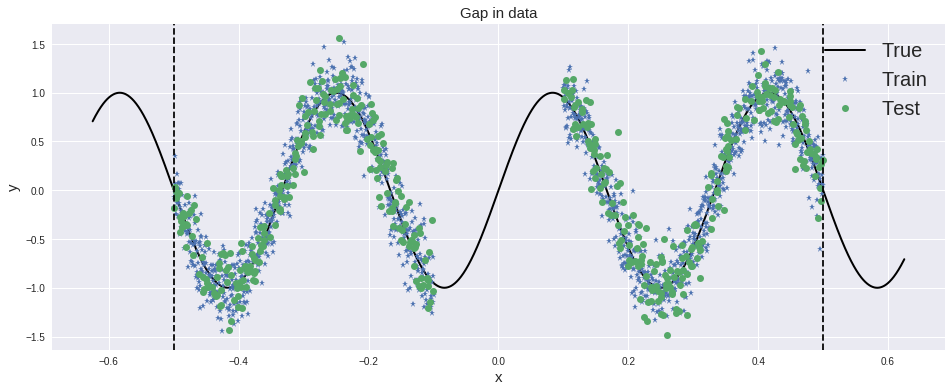

In [10]:
plt.figure(figsize=(16,6))
plt.plot(X_pred, y_pred, '-k', linewidth=2.0, label='True')
plt.plot(X_train_gap, y_train_gap, '*', label='Train')
plt.plot(X_test_gap, y_test_gap, 'o', label='Test')
plt.axvline(x=a, color='k', linestyle='--')
plt.axvline(x=b, color='k', linestyle='--')
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.title('Gap in data', fontsize=15)
plt.legend(fontsize=20)
plt.show()

## Feed forward neural network

### Build network

In [0]:
def build_ffnn(activation, kernel_initializer):
    X = Input(shape=(1,))
    h = Dense(units=16, activation=activation, kernel_initializer=kernel_initializer)(X)
    h = Dense(units=16, activation=activation, kernel_initializer=kernel_initializer)(h)
    h = Dropout(0.1)(h)
    h = Dense(units=16, activation=activation, kernel_initializer=kernel_initializer)(h)
    h = Dense(units=16, activation=activation, kernel_initializer=kernel_initializer)(h)
    y = Dense(units=1, activation='linear', kernel_initializer=kernel_initializer)(h)
    model = Model(inputs=X, outputs=y)
    
    return model

### Optimizer

In [0]:
def compile_ffnn(model, lr):
    adam = Adam(lr=lr, 
                beta_1=0.9, 
                beta_2=0.999, 
                epsilon=None, 
                decay=0.0, 
                amsgrad=False)
    model.compile(loss='mean_squared_error', optimizer=adam)
    
    return model

### Predict

In [0]:
def predict_MC(model, X, nb_MC_samples):
    MC_output = K.function([model.layers[0].input, K.learning_phase()], [model.layers[-1].output])
    learning_phase = True  # Use dropout at test pass
    y_MC = [MC_output([X, learning_phase])[0][:,0] for _ in range(nb_MC_samples)]
    y_MC = np.transpose(np.array(y_MC), axes=(1,0))
    
    return y_MC

### Prediction before training

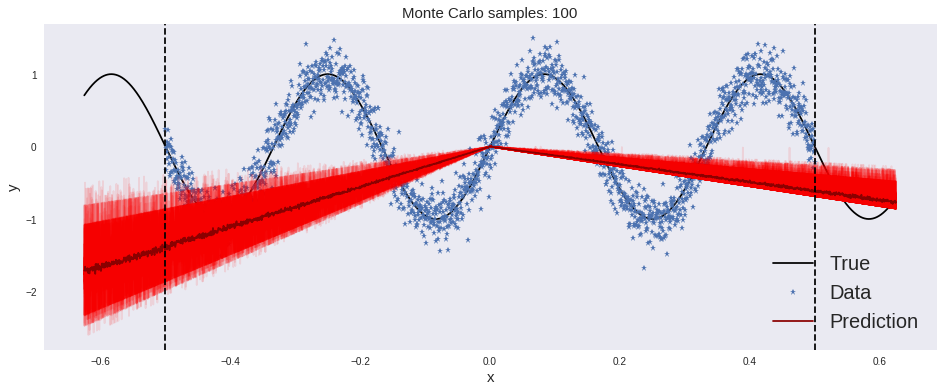

In [14]:
model_full = build_ffnn(activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.5, seed=None))
nb_MC_samples = 100
y_pred_MC = predict_MC(model_full, X_pred, nb_MC_samples)

plt.figure(figsize=(16,6))
plt.plot(X_pred, y_pred, '-k', label='True')
plt.plot(x_data_full, y_data_full, '*', label='Data')
plt.plot(X_pred, y_pred_MC, 'r', alpha=0.1)
plt.plot(X_pred, y_pred_MC.mean(axis=1), color='darkred', label='Prediction')

plt.axvline(x=a, color='k', linestyle='--')
plt.axvline(x=b, color='k', linestyle='--')
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.title('Monte Carlo samples: '+str(nb_MC_samples), fontsize=15)
plt.legend(fontsize=20)
plt.grid()
plt.show()

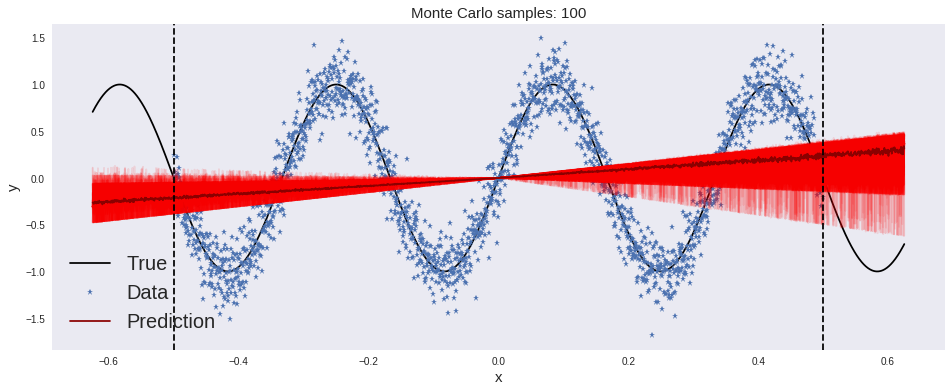

In [15]:
model_full = build_ffnn(activation='relu', kernel_initializer=RandomUniform(minval=-0.8, maxval=0.8))
nb_MC_samples = 100
y_pred_MC = predict_MC(model_full, X_pred, nb_MC_samples)

plt.figure(figsize=(16,6))
plt.plot(X_pred, y_pred, '-k', label='True')
plt.plot(x_data_full, y_data_full, '*', label='Data')
plt.plot(X_pred, y_pred_MC, 'r', alpha=0.1)
plt.plot(X_pred, y_pred_MC.mean(axis=1), color='darkred', label='Prediction')

plt.axvline(x=a, color='k', linestyle='--')
plt.axvline(x=b, color='k', linestyle='--')
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.title('Monte Carlo samples: '+str(nb_MC_samples), fontsize=15)
plt.legend(fontsize=20)
plt.grid()
plt.show()

## Train model

### Full

In [0]:
model_full = build_ffnn(activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.5))

In [0]:
n_epoch = 0
train_loss = np.array([])
test_loss = np.array([])

In [18]:
batch_size = 64 
lr = 1e-3
model_full = compile_ffnn(model_full, lr)
n_epoch_add = 200

n_epoch_final = n_epoch+n_epoch_add
history = model_full.fit(x=X_train_full, y=y_train_full, validation_data=(X_test_full, y_test_full), epochs=n_epoch_final, initial_epoch=n_epoch, batch_size=batch_size, verbose=2)
train_loss = np.append(train_loss, history.history['loss'])
test_loss = np.append(test_loss, history.history['val_loss'])
n_epoch = n_epoch_final

Train on 1500 samples, validate on 500 samples
Epoch 1/200
 - 0s - loss: 0.5366 - val_loss: 0.5249
Epoch 2/200
 - 0s - loss: 0.5103 - val_loss: 0.5146
Epoch 3/200
 - 0s - loss: 0.5001 - val_loss: 0.5008
Epoch 4/200
 - 0s - loss: 0.4928 - val_loss: 0.4912
Epoch 5/200
 - 0s - loss: 0.4841 - val_loss: 0.4788
Epoch 6/200
 - 0s - loss: 0.4716 - val_loss: 0.4679
Epoch 7/200
 - 0s - loss: 0.4571 - val_loss: 0.4546
Epoch 8/200
 - 0s - loss: 0.4459 - val_loss: 0.4414
Epoch 9/200
 - 0s - loss: 0.4287 - val_loss: 0.4245
Epoch 10/200
 - 0s - loss: 0.4125 - val_loss: 0.4065
Epoch 11/200
 - 0s - loss: 0.4011 - val_loss: 0.3928
Epoch 12/200
 - 0s - loss: 0.3850 - val_loss: 0.3572
Epoch 13/200
 - 0s - loss: 0.3632 - val_loss: 0.3350
Epoch 14/200
 - 0s - loss: 0.3356 - val_loss: 0.3068
Epoch 15/200
 - 0s - loss: 0.3200 - val_loss: 0.2842
Epoch 16/200
 - 0s - loss: 0.2986 - val_loss: 0.2622
Epoch 17/200
 - 0s - loss: 0.2776 - val_loss: 0.2386
Epoch 18/200
 - 0s - loss: 0.2613 - val_loss: 0.2152
Epoch 19

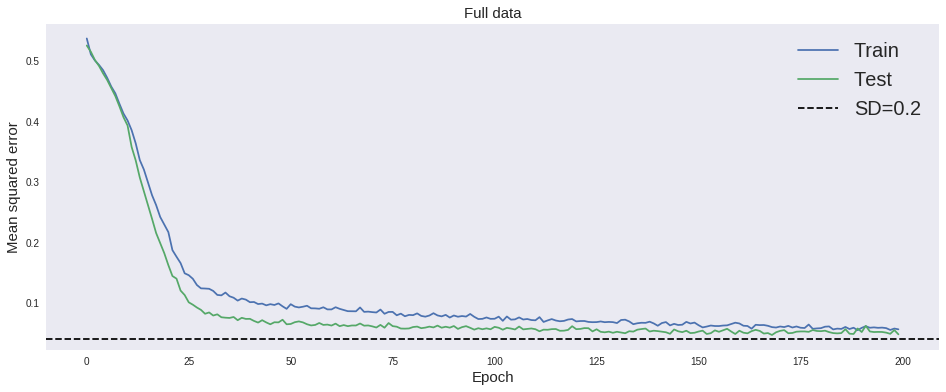

In [19]:
plt.figure(figsize=(16,6))
plt.plot(range(len(train_loss)), train_loss, label='Train')
plt.plot(range(len(test_loss)), test_loss, label='Test')
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Mean squared error', fontsize=15)
plt.title('Full data', fontsize=15)
plt.axhline(0.2**2, linestyle='--', color='k', label='SD=0.2')
plt.legend(fontsize=20)
plt.grid()
plt.show()

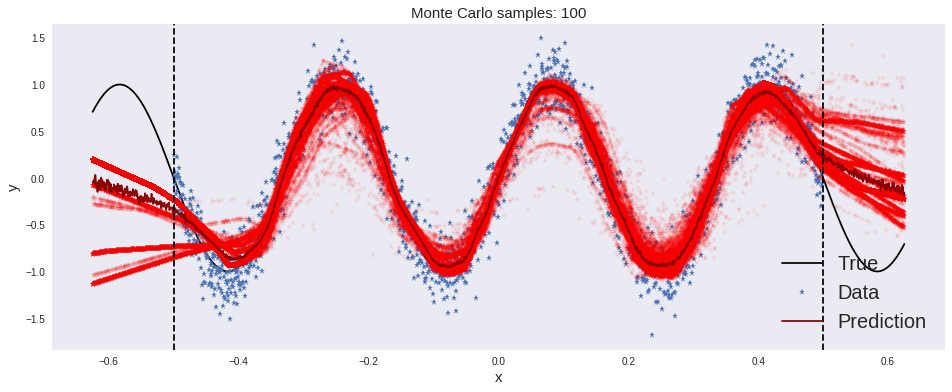

In [20]:
nb_MC_samples = 100
y_pred_MC = predict_MC(model_full, X_pred, nb_MC_samples)

plt.figure(figsize=(16,6))
plt.plot(X_pred, y_pred, '-k', label='True')
plt.plot(x_data_full, y_data_full, '*', label='Data')
plt.plot(X_pred, y_pred_MC, 'r*', alpha=0.1)
plt.plot(X_pred, y_pred_MC.mean(axis=1), color='darkred', label='Prediction')

plt.axvline(x=a, color='k', linestyle='--')
plt.axvline(x=b, color='k', linestyle='--')
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.title('Monte Carlo samples: '+str(nb_MC_samples), fontsize=15)
plt.legend(fontsize=20)
plt.grid()
plt.show()

### Gap

In [0]:
model_gap = build_ffnn(activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.5, seed=None))

In [0]:
n_epoch = 0
train_loss = np.array([])
test_loss = np.array([])

In [0]:
lr = 1e-3
model_gap = compile_ffnn(model_gap, lr)
n_epoch_add = 200

n_epoch_final = n_epoch+n_epoch_add
history = model_gap.fit(x=X_train_gap, y=y_train_gap, validation_data=(X_test_gap, y_test_gap), epochs=n_epoch_final, initial_epoch=n_epoch, batch_size=64, verbose=2)
train_loss = np.append(train_loss, history.history['loss'])
test_loss = np.append(test_loss, history.history['val_loss'])
n_epoch = n_epoch_final

Train on 1500 samples, validate on 500 samples
Epoch 1/200
 - 0s - loss: 0.4981 - val_loss: 0.5192
Epoch 2/200
 - 0s - loss: 0.4713 - val_loss: 0.4993
Epoch 3/200
 - 0s - loss: 0.4615 - val_loss: 0.4799
Epoch 4/200
 - 0s - loss: 0.4433 - val_loss: 0.4605
Epoch 5/200
 - 0s - loss: 0.4261 - val_loss: 0.4390
Epoch 6/200
 - 0s - loss: 0.4052 - val_loss: 0.4113
Epoch 7/200
 - 0s - loss: 0.3851 - val_loss: 0.3862
Epoch 8/200
 - 0s - loss: 0.3654 - val_loss: 0.3651
Epoch 9/200
 - 0s - loss: 0.3418 - val_loss: 0.3381
Epoch 10/200
 - 0s - loss: 0.3213 - val_loss: 0.3112
Epoch 11/200
 - 0s - loss: 0.2964 - val_loss: 0.2847
Epoch 12/200
 - 0s - loss: 0.2848 - val_loss: 0.2626
Epoch 13/200
 - 0s - loss: 0.2592 - val_loss: 0.2512
Epoch 14/200
 - 0s - loss: 0.2456 - val_loss: 0.2273
Epoch 15/200
 - 0s - loss: 0.2241 - val_loss: 0.2024
Epoch 16/200
 - 0s - loss: 0.2104 - val_loss: 0.1895
Epoch 17/200
 - 0s - loss: 0.2014 - val_loss: 0.1736
Epoch 18/200
 - 0s - loss: 0.1855 - val_loss: 0.1613
Epoch 19

Epoch 154/200
 - 0s - loss: 0.0553 - val_loss: 0.0492
Epoch 155/200
 - 0s - loss: 0.0580 - val_loss: 0.0508
Epoch 156/200
 - 0s - loss: 0.0561 - val_loss: 0.0465
Epoch 157/200
 - 0s - loss: 0.0562 - val_loss: 0.0528
Epoch 158/200
 - 0s - loss: 0.0572 - val_loss: 0.0523
Epoch 159/200
 - 0s - loss: 0.0576 - val_loss: 0.0566
Epoch 160/200
 - 0s - loss: 0.0527 - val_loss: 0.0470
Epoch 161/200
 - 0s - loss: 0.0559 - val_loss: 0.0490
Epoch 162/200
 - 0s - loss: 0.0555 - val_loss: 0.0482
Epoch 163/200
 - 0s - loss: 0.0554 - val_loss: 0.0475
Epoch 164/200
 - 0s - loss: 0.0534 - val_loss: 0.0508
Epoch 165/200
 - 0s - loss: 0.0533 - val_loss: 0.0495
Epoch 166/200
 - 0s - loss: 0.0564 - val_loss: 0.0523
Epoch 167/200
 - 0s - loss: 0.0543 - val_loss: 0.0449
Epoch 168/200
 - 0s - loss: 0.0554 - val_loss: 0.0536
Epoch 169/200
 - 0s - loss: 0.0559 - val_loss: 0.0464
Epoch 170/200
 - 0s - loss: 0.0561 - val_loss: 0.0490
Epoch 171/200
 - 0s - loss: 0.0584 - val_loss: 0.0496
Epoch 172/200
 - 0s - loss: 

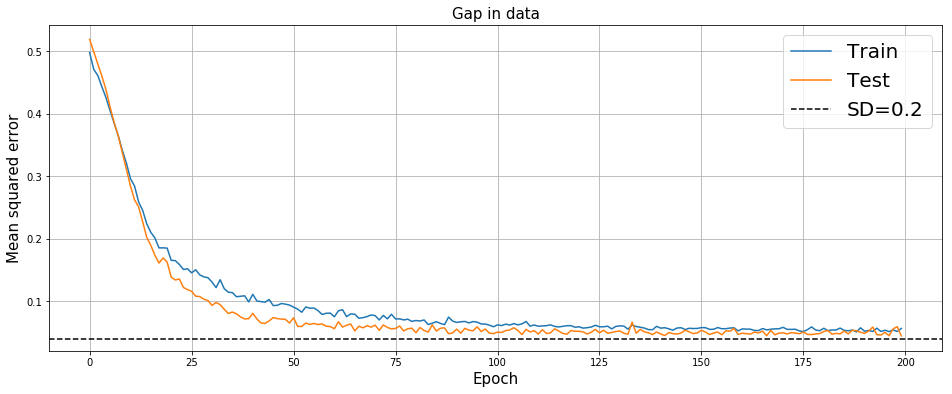

In [0]:
plt.figure(figsize=(16,6))
plt.plot(range(len(train_loss)), train_loss, label='Train')
plt.plot(range(len(test_loss)), test_loss, label='Test')
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Mean squared error', fontsize=15)
plt.title('Gap in data', fontsize=15)
plt.axhline(0.2**2, linestyle='--', color='k', label='SD=0.2')
plt.legend(fontsize=20)
plt.grid()
plt.show()

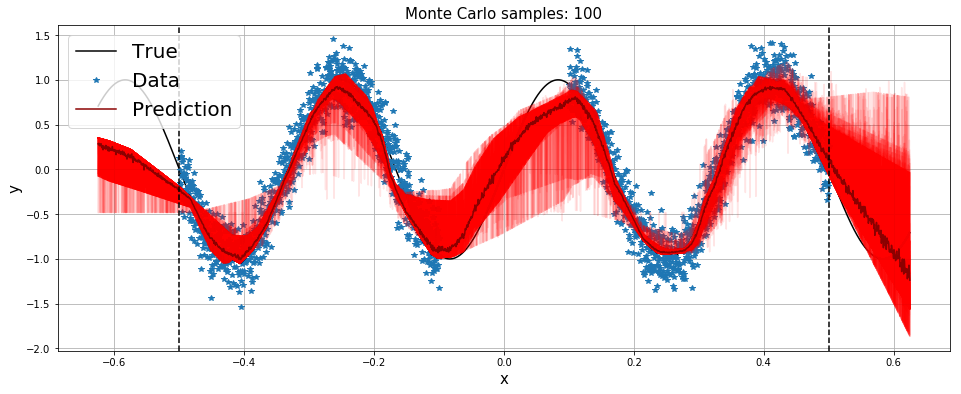

In [0]:
nb_MC_samples = 100
y_pred_MC = predict_MC(model_gap, X_pred, nb_MC_samples)

plt.figure(figsize=(16,6))
plt.plot(X_pred, y_pred, '-k', label='True')
plt.plot(x_data_gap, y_data_gap, '*', label='Data')
plt.plot(X_pred, y_pred_MC, 'r', alpha=0.1)
plt.plot(X_pred, y_pred_MC.mean(axis=1), color='darkred', label='Prediction')
plt.axvline(x=a, color='k', linestyle='--')
plt.axvline(x=b, color='k', linestyle='--')
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.title('Monte Carlo samples: '+str(nb_MC_samples), fontsize=15)
plt.legend(fontsize=20)
plt.grid()
plt.show()